In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

%matplotlib inline

# load data and train a simple model

In [2]:
mnist = pd.read_csv("data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print ("dimension de las imagenes y las clases", X.shape, y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train
X_test  = X_test
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]
print (X_train.shape, y_train_oh.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)
(1200, 784) (1200, 10)


In [3]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input
from tensorflow.keras.backend import clear_session
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
tf.__version__

'1.13.1'

In [4]:
def get_model(input_dim=784, output_dim=10, layer_sizes=[10]*6, activation="relu", sigma=1):
    
    clear_session()
    model = Sequential()

    model.add(Dense(layer_sizes[0], activation=activation, input_dim=input_dim, name="Layer_%02d_Input"%(0)))
   
    for i, hsize in enumerate(layer_sizes[1:]):
        model.add(Dense(hsize, activation=activation, name="Layer_%02d_Hidden"%(i+1)))
   
    model.add(Dense(output_dim, activation="softmax", name="Layer_%02d_Output"%(len(layer_sizes))))
        
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.reset_states()
    return model

def get_tensors_and_functions(model):
    T_input     = model.input                                        
    T_outputs   = [layer.output for layer in model.layers]         
    T_weights   = model.trainable_weights
    T_gradients = model.optimizer.get_gradients(model.total_loss, T_weights)
    F_outputs   = [K.function([T_input, K.learning_phase()], [out]) for out in T_outputs]    
    F_gradients = [K.function(inputs=[T_input, model.targets[0],  
                                      K.learning_phase()], outputs=[grad]) for grad in T_gradients]

    return T_input, T_outputs, T_weights, T_gradients, F_outputs, F_gradients





In [5]:
model = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=20)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_00_Input (Dense)       (None, 20)                15700     
_________________________________________________________________
Layer_01_Hidden (Dense)      (None, 15)                315       
_________________________________________________________________
Layer_02_Hidden (Dense)      (None, 15)                240       
_________________________________________________________________
Layer_03_Output (Dense)      (None, 10)                160       
Total params: 16,415
Trainable params: 16,415
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.fit(X_train, y_train_oh, epochs=30, batch_size=32, validation_data=(X_test, y_test_oh))


Train on 1200 samples, validate on 300 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
1200/1200 [==============================] - 0s 208us/sample - loss: 2.5293 - acc: 0.1000 - val_loss: 2.3443 - val_acc: 0.1233
Epoch 2/30
1200/1200 [==============================] - 0s 65us/sample - loss: 2.3768 - acc: 0.1000 - val_loss: 2.2754 - val_acc: 0.1233
Epoch 3/30
1200/1200 [==============================] - 0s 58us/sample - loss: 2.3053 - acc: 0.1000 - val_loss: 2.2337 - val_acc: 0.1233
Epoch 4/30
1200/1200 [==============================] - 0s 66us/sample - loss: 2.2541 - acc: 0.1000 - val_loss: 2.1952 - val_acc: 0.1233
Epoch 5/30
1200/1200 [==============================] - 0s 84us/sample - loss: 2.2055 - acc: 0.1592 - val_loss: 2.1466 - val_acc: 0.2167
Epoch 6/30
1200/1200 [==============================] - 0s 70us/sample - loss: 2.1505 - acc: 0.1692 - val_loss: 2.0904 - val_acc: 0.2533
Epoch 7/30
1200/1200 [==============================] - 0s 63us/sample - loss: 2.0

## we inspect programmatically the model structure with keras

### first, we obtain the actual weights resulting from training the model

In [7]:
mW = model.get_weights()
W = [{"weights": mW[i], "bias": mW[i+1]} for i in range(0,len(mW),2)]
for i in range(len(W)):
    print ("Layer %i.weights"%i, W[i]["weights"].shape)
    print ("Layer %i.bias   "%i, W[i]["bias"].shape   )
    
print (W[0]["weights"])

Layer 0.weights (784, 20)
Layer 0.bias    (20,)
Layer 1.weights (20, 15)
Layer 1.bias    (15,)
Layer 2.weights (15, 15)
Layer 2.bias    (15,)
Layer 3.weights (15, 10)
Layer 3.bias    (10,)
[[-0.03443924 -0.00238148  0.01480068 ...  0.0112726  -0.0825302
   0.01180405]
 [ 0.07089245 -0.07286802 -0.07535192 ...  0.01091126  0.04079525
   0.06651439]
 [ 0.07510205 -0.01404362  0.0516184  ...  0.00151736  0.07651143
   0.07134171]
 ...
 [-0.01438238  0.00559779  0.0227362  ... -0.04969458  0.00553783
  -0.04501259]
 [ 0.01181132  0.05136217 -0.08011606 ...  0.04674883  0.00631781
  -0.07835934]
 [ 0.05129735  0.04655932 -0.08471573 ...  0.02702058 -0.03029588
  -0.00102819]]


### then, we obtain tensors representing:

- the input
- each layer output
- all weights
- all gradients

### and functions for:
 - each layer output
 - gradients at for each layer weights and biases

In [8]:
T_input, T_outputs, T_weights, T_gradients, F_outputs, F_gradients = get_tensors_and_functions(model)

In [9]:
T_input

<tf.Tensor 'Layer_00_Input_input:0' shape=(?, 784) dtype=float32>

In [10]:
T_outputs

[<tf.Tensor 'Layer_00_Input/Sigmoid:0' shape=(?, 20) dtype=float32>,
 <tf.Tensor 'Layer_01_Hidden/Sigmoid:0' shape=(?, 15) dtype=float32>,
 <tf.Tensor 'Layer_02_Hidden/Sigmoid:0' shape=(?, 15) dtype=float32>,
 <tf.Tensor 'Layer_03_Output/Softmax:0' shape=(?, 10) dtype=float32>]

In [11]:
T_weights

[<tf.Variable 'Layer_00_Input/kernel:0' shape=(784, 20) dtype=float32>,
 <tf.Variable 'Layer_00_Input/bias:0' shape=(20,) dtype=float32>,
 <tf.Variable 'Layer_01_Hidden/kernel:0' shape=(20, 15) dtype=float32>,
 <tf.Variable 'Layer_01_Hidden/bias:0' shape=(15,) dtype=float32>,
 <tf.Variable 'Layer_02_Hidden/kernel:0' shape=(15, 15) dtype=float32>,
 <tf.Variable 'Layer_02_Hidden/bias:0' shape=(15,) dtype=float32>,
 <tf.Variable 'Layer_03_Output/kernel:0' shape=(15, 10) dtype=float32>,
 <tf.Variable 'Layer_03_Output/bias:0' shape=(10,) dtype=float32>]

In [12]:
T_gradients

[<tf.Tensor 'gradients/Layer_00_Input/MatMul_grad/MatMul_1:0' shape=(784, 20) dtype=float32>,
 <tf.Tensor 'gradients/Layer_00_Input/BiasAdd_grad/BiasAddGrad:0' shape=(20,) dtype=float32>,
 <tf.Tensor 'gradients/Layer_01_Hidden/MatMul_grad/MatMul_1:0' shape=(20, 15) dtype=float32>,
 <tf.Tensor 'gradients/Layer_01_Hidden/BiasAdd_grad/BiasAddGrad:0' shape=(15,) dtype=float32>,
 <tf.Tensor 'gradients/Layer_02_Hidden/MatMul_grad/MatMul_1:0' shape=(15, 15) dtype=float32>,
 <tf.Tensor 'gradients/Layer_02_Hidden/BiasAdd_grad/BiasAddGrad:0' shape=(15,) dtype=float32>,
 <tf.Tensor 'gradients/Layer_03_Output/MatMul_grad/MatMul_1:0' shape=(15, 10) dtype=float32>,
 <tf.Tensor 'gradients/Layer_03_Output/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float32>]

In [13]:
F_outputs

In [14]:
F_gradients

### now we can use the function to compute stuff along the network

**the output at input Layer when feeding test data**

In [15]:
F_outputs[0]([X_test])[0]

array([[0.03880924, 0.06122208, 0.99341106, ..., 0.9745477 , 0.99470127,
        0.00266472],
       [0.33530396, 0.9980502 , 0.01646429, ..., 0.9879525 , 0.7460462 ,
        0.66868705],
       [0.36736047, 0.9858327 , 0.01900828, ..., 0.8312223 , 0.99076086,
        0.00531802],
       ...,
       [0.07552645, 0.9930215 , 0.02449641, ..., 0.9855243 , 0.51385033,
        0.39826375],
       [0.7581127 , 0.7499939 , 0.17297423, ..., 0.95885646, 0.9167014 ,
        0.0892258 ],
       [0.4931406 , 0.950323  , 0.13040483, ..., 0.7938317 , 0.852847  ,
        0.10235044]], dtype=float32)

and its equivalent if we do the math

In [16]:
sigm = lambda x: 1./(1.+np.exp(-x))
sigm(X_test.dot(W[0]["weights"])+W[0]["bias"])

array([[0.03880932, 0.06122206, 0.99341106, ..., 0.97454767, 0.99470121,
        0.00266475],
       [0.33530419, 0.99805023, 0.01646431, ..., 0.98795249, 0.74604621,
        0.66868701],
       [0.36736039, 0.98583274, 0.01900827, ..., 0.83122228, 0.99076089,
        0.00531796],
       ...,
       [0.07552647, 0.99302153, 0.02449637, ..., 0.98552431, 0.51385031,
        0.3982637 ],
       [0.7581127 , 0.74999375, 0.17297422, ..., 0.95885656, 0.91670138,
        0.08922584],
       [0.49314063, 0.95032298, 0.13040486, ..., 0.79383166, 0.85284695,
        0.10235047]])

**the output at layer 0, before the sigmoid**

- we need to dig into the computational graph.
- `T_outputs[0].op.inputs[0]` points to the input of the sigmoid function, this is $XW+b$.

In [17]:
T_outputs[0].op.inputs[0]

<tf.Tensor 'Layer_00_Input/BiasAdd:0' shape=(?, 20) dtype=float32>

In [18]:
T_outputs[2].op.inputs[0].op.inputs[0].op.inputs[0].op.inputs[0].op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'Layer_00_Input/BiasAdd:0' shape=(?, 20) dtype=float32>

In [19]:
XW0 = K.function([T_input, K.learning_phase()], [T_outputs[0].op.inputs[0]])
XW0([X_test])[0]

array([[-3.2095125 , -2.7300708 ,  5.015752  , ...,  3.6451666 ,
         5.2349644 , -5.924978  ],
       [-0.6842925 ,  6.238092  , -4.0899596 , ...,  4.4067764 ,
         1.0776353 ,  0.7022529 ],
       [-0.54355735,  4.242552  , -3.9436903 , ...,  1.5943148 ,
         4.6750274 , -5.2313333 ],
       ...,
       [-2.5047412 ,  4.9579225 , -3.684429  , ...,  4.220703  ,
         0.05541544, -0.41270486],
       [ 1.1423603 ,  1.0985796 , -1.5646933 , ...,  3.148677  ,
         2.3983495 , -2.3231242 ],
       [-0.02743932,  2.95126   , -1.897384  , ...,  1.3481787 ,
         1.7571069 , -2.1713767 ]], dtype=float32)

and doing the math, just to check

In [20]:
X_test.dot(W[0]["weights"])+W[0]["bias"]

array([[-3.2095123 , -2.73007135,  5.01575198, ...,  3.64516612,
         5.23496473, -5.9249778 ],
       [-0.68429136,  6.23808995, -4.08995864, ...,  4.40677664,
         1.07763524,  0.70225257],
       [-0.54355755,  4.24255269, -3.94368999, ...,  1.59431465,
         4.67502726, -5.2313332 ],
       ...,
       [-2.50474125,  4.95792289, -3.68442904, ...,  4.22070317,
         0.05541543, -0.41270497],
       [ 1.14236015,  1.09857894, -1.56469334, ...,  3.14867691,
         2.39834975, -2.32312431],
       [-0.02743919,  2.95125952, -1.8973838 , ...,  1.34817843,
         1.75710694, -2.17137682]])

**the gradients of params at layer 0**

observe how we need to feed **both** input and output to the gradients function. Output has to be in one hot encoding.

In [23]:
g = F_gradients[0]([X_train, y_train_oh])[0]
print (g.shape)
g

(784, 20)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## We now inspect the distributions of weights, outputs and gradients of Layer 0

In [24]:
def show_layer0_output():
    weights=W[0]["weights"]
    bias=W[0]["bias"]
    O = (X_train.dot(weights)+bias).reshape(-1)
    S = sigm(O)
    plt.figure(figsize=(20,3))
    plt.subplot(141)
    plt.hist(O, bins=30, density=True);
    plt.xlabel("$XW_{0}+b_{0}$")
    plt.subplot(142)
    plt.hist(S, bins=30, density=True);
    plt.xlabel("$sigm(XW_0+b_0)$")
    plt.subplot(143)
    plt.hist(weights.reshape(-1), bins=30,density=True);
    plt.xlabel("$W_{0}$")
    plt.subplot(144)
    g = F_gradients[0]([X_train, y_train_oh])[0].reshape(-1)
    plt.hist(g, bins=30,density=True);
    plt.xlabel("gradients")

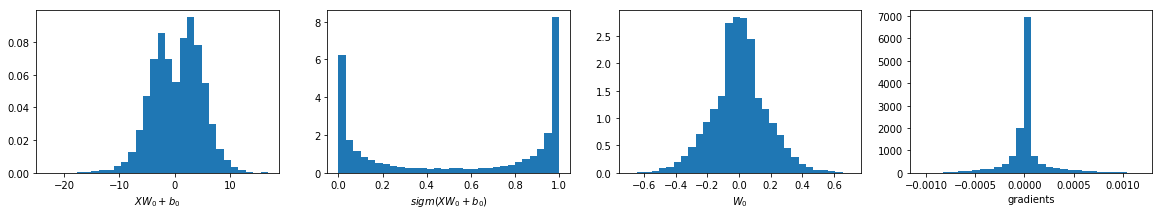

In [25]:
show_layer0_output()